In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pyro import distributions as dist
from pyrofit.lensing.utils import get_meshgrid
from pyrofit.lensing.lenses import SPLELens
from pyrofit.lensing.sources import SersicSource
from swyft.networks.channelized import LinearWithChannel, BatchNorm1dWithChannel

torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.cuda.FloatTensor)

import swyft

DEVICE='cuda'

In [25]:
SIGMA = 0.1

In [26]:
def image_generator(x, y, phi, q, r_ein, slope, x_src, y_src, phi_src, q_src, index, r_e, I_e):

    res = 0.0125*8                      # resolution in arcsec
    nx, ny = 50, 50                   # number of pixels
    X, Y = get_meshgrid(res, nx, ny)    # grid

    # Lens
    lens = SPLELens(device=DEVICE)
    lens.XY = X,Y
    # Displacement field
    alphas = lens(x=x, y=y, phi=phi, q=q, r_ein=r_ein, slope=slope)

    # Lensing equation
    X_src = X - alphas[..., 0, :, :]
    Y_src = Y - alphas[..., 1, :, :]

    # Source
    sersic = SersicSource(device=DEVICE)

    # Lensed source
    image = sersic(X=X_src, Y=Y_src, x=x_src, y=y_src, phi=phi_src, q=q_src, index=index, r_e=r_e, I_e=I_e)
    
    return image.cpu().numpy()

In [27]:
def model(v):
    # Lens parameters
    x = -0.05
    y = 0.1
    phi = 1.
    q = 0.5
    #r_ein = 1.4
    slope = 2.1
    #x, y, phi, q, r_ein, slope, x_src, y_src, phi_src, q_src, index, r_e, I_e = v
    r_ein = v[0]
    
    # Source param
    x_src = 0.
    y_src = 0.
    phi_src = 1.5
    q_src =0.7
    index = 2.
    r_e = 1.5
    I_e = 1.
    
    img = image_generator(x, y, phi, q, r_ein, slope, x_src, y_src, phi_src, q_src, index, r_e, I_e)
    return dict(img = img)

In [28]:
def noise(sim, v, sigma = SIGMA):
    return dict(img = sim['img'] + np.random.randn(50, 50)*sigma)

In [29]:
low =  np.array([1.38])
high = np.array([1.42])
prior = swyft.get_uniform_prior(low, high)

In [30]:
sim = swyft.Simulator(model, 1, dict(img=(50,50)))

In [31]:
Ntrain = 300

store = swyft.Store.memory_store(sim)
store.add(Ntrain, prior)
store.simulate()

Creating new store.
Store: Adding 282 new samples to simulator store.


In [32]:
torch.set_default_tensor_type(torch.FloatTensor)  # Needing this is kinda stupid

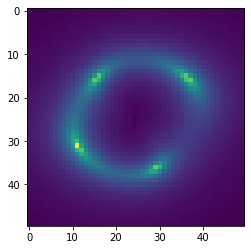

In [33]:
plt.imshow(store[4][0]['img'])

In [34]:
dataset = swyft.Dataset(Ntrain, prior, store, simhook = noise)

In [35]:
class CustomObservationTransform(torch.nn.Module):
    def __init__(self, observation_key: str, observation_shapes: dict):
        super().__init__()
        self.observation_key = observation_key  # Internal usage
        self.n_features = 2  # This attribute must be defined!
        
        self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(observation_shapes)
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(10, 20, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(20, 40, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.LazyLinear(2),
        )

    def forward(self, obs: dict) -> torch.Tensor:
        x = self.online_z_score(obs)
        x = x[self.observation_key]
        x = x.unsqueeze(1)
        x = self.net(x).squeeze(1)
        return x

In [36]:
class CustomMarginalClassifier(torch.nn.Module):
    def __init__(
        self,
        n_marginals: int,
        n_combined_features: int,
        hidden_features: int,
        num_blocks=2,
    ) -> None:
        super().__init__()
        self.n_marginals = n_marginals
        self.n_combined_features = n_combined_features
        
        blocks = [
            LinearWithChannel(self.n_marginals, self.n_combined_features, hidden_features),
            torch.nn.ReLU(),
            BatchNorm1dWithChannel(self.n_marginals, hidden_features),
        ]
        for _ in range(num_blocks - 1):
            blocks.append(LinearWithChannel(self.n_marginals, hidden_features, hidden_features))
            blocks.append(torch.nn.ReLU())
            blocks.append(BatchNorm1dWithChannel(self.n_marginals, hidden_features))
        
        self.net = torch.nn.Sequential(
            *blocks,
            LinearWithChannel(self.n_marginals, hidden_features, 1)
        )

    def forward(
        self, features: torch.Tensor, marginal_block: torch.Tensor
    ) -> torch.Tensor:
        fb = features.unsqueeze(1).expand(-1, self.n_marginals, -1)  # B, M, O
        combined = torch.cat([fb, marginal_block], dim=2)  # B, M, O + P
        return self.net(combined).squeeze(-1)  # B, M

In [37]:
marg_indices = tuple([(i,) for i in range(1)])

In [39]:
#obstrans = swyft.networks.ObservationTransform('img', {'img': (50, 50)}, True)
#partrans = swyft.networks.ParameterTransform(1, marg_indices, True)
#margclass = swyft.networks.MarginalClassifier(1, 50*50+1, 32, 2)

obstrans = CustomObservationTransform('img', {'img': (50, 50)})
partrans = swyft.networks.ParameterTransform(1, marg_indices, True)
margclass = CustomMarginalClassifier(1, 2+1, 32, 2)

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [40]:
network_1d = swyft.networks.Network(obstrans, partrans, margclass)

In [41]:
mre_1d = swyft.MarginalRatioEstimator(
    marginal_indices=marg_indices,
    network=network_1d,
    device=DEVICE,
)

In [42]:
vl = mre_1d.train(dataset, batch_size = 64, max_epochs = 100)

training: lr=0.0005, epoch=25, validation loss=0.7854


In [19]:
posterior_1d = swyft.MarginalPosterior(mre_1d, prior)

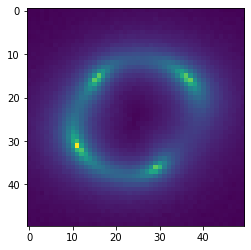

In [20]:
obs0, _, v0 = dataset[0]
samples_1d = posterior_1d.weighted_sample(100000, obs0)
plt.imshow(obs0['img'])

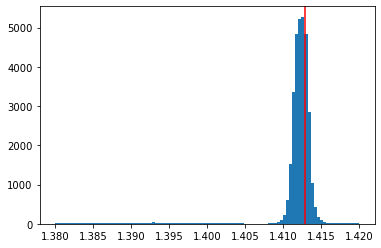

In [21]:
w = np.exp(samples_1d.weights[(0,)])
x = samples_1d.v[:,0]
plt.hist(x, weights=w, bins = 100);
plt.axvline(v0.item(), color='r')

In [22]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

mu0 = obs0['img'].cpu().numpy()

def loglike(v):
    img = model(np.array([v]))['img']
    diff = img - mu0
    return 0.5*(diff**2).sum()/SIGMA**2

lls = np.array([loglike(v) for v in np.linspace(1.38, 1.42, 100)])

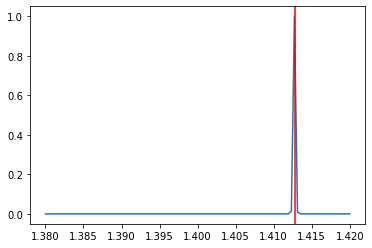

In [23]:
lls -= lls.min()
plt.plot(np.linspace(1.38, 1.42, 100), np.exp(-lls))
plt.axvline(v0.item(), color='r')